# Setup

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import cirq

# Converting from Second Quantization to Pauli Operators

In [2]:
from openfermion.ops import FermionOperator
from openfermion.utils import hermitian_conjugated
from openfermion.transforms import jordan_wigner

In [3]:
t = 2.
U = 1.

t_term = FermionOperator('1^ 0', -t)
t_term += hermitian_conjugated(t_term)

U_term = FermionOperator('0^ 0 1^ 1', U)

hamiltonian = t_term + U_term

print(hamiltonian)

1.0 [0^ 0 1^ 1] +
-2.0 [0^ 1] +
-2.0 [1^ 0]


In [4]:
transformed_hamiltonian = jordan_wigner(hamiltonian)
transformed_hamiltonian.compress()

print(transformed_hamiltonian)

0.25 [] +
-1.0 [X0 X1] +
-1.0 [Y0 Y1] +
-0.25 [Z0] +
0.25 [Z0 Z1] +
-0.25 [Z1]


# Creating the Ansatz Circuit

In [5]:
def full_circuit(alpha,beta,key,show=False):
    
    # 2 qubits
    qb = [cirq.LineQubit(i) for i in range(2)]
    
    # This is the basic part of the circuit
    circuit = cirq.Circuit()
    circuit.append(cirq.Y(qb[0])**alpha)
    circuit.append(cirq.X(qb[1])**beta, strategy=cirq.InsertStrategy.EARLIEST)
    circuit.append(cirq.CNOT(qb[0],qb[1]))
    
    # For some parts you have to change the measurement basis
    if 'X0' in key:
        circuit.append(cirq.H(qb[0]))
    elif 'Y0' in key:
        circuit.append(cirq.S(qb[0])**-1)
        circuit.append(cirq.H(qb[0]))
    if 'X1' in key:
        circuit.append(cirq.H(qb[1]), strategy=cirq.InsertStrategy.EARLIEST)
    elif 'Y1' in key:
        circuit.append(cirq.S(qb[1])**-1, strategy=cirq.InsertStrategy.EARLIEST)
        circuit.append(cirq.H(qb[1]), strategy=cirq.InsertStrategy.EARLIEST)
        
    circuit.append(cirq.measure(*qb, key=key))       
    return circuit

In [6]:
full_circuit(0.3,0.2,'',show=True)

0: ───Y^0.3───@───M('')───
              │   │
1: ───X^0.2───X───M───────

# Expectation Value of one Pauli term, for one Measurement

In [7]:
def energy_func(key):
    
    def energy(measurements):
        # Convert true/false to +1/-1.
        pm_meas = 1 - 2 * np.array(measurements).astype(np.int32)
        
        # Calculate the expectation value of one Pauli term and multiply by the coefficient,
        # for one measurement result
        if key is '':
            coeff = transformed_hamiltonian.terms[()]
            tot_energy = coeff
        elif key is 'Z0':
            coeff = transformed_hamiltonian.terms[((0, 'Z'),)]
            tot_energy = coeff * pm_meas[0]
        elif key is 'Z1':
            coeff = transformed_hamiltonian.terms[((1, 'Z'),)]
            tot_energy = coeff * pm_meas[1]
        elif key is 'Z0Z1':
            coeff = transformed_hamiltonian.terms[((0, 'Z'), (1, 'Z'))]
            tot_energy = coeff * pm_meas[0] * pm_meas[1]
        elif key is 'X0X1':
            coeff = transformed_hamiltonian.terms[((0, 'X'), (1, 'X'))]
            tot_energy = coeff * pm_meas[0] * pm_meas[1]
        elif key is 'Y0Y1':
            coeff = transformed_hamiltonian.terms[((0, 'Y'), (1, 'Y'))]
            tot_energy = coeff * pm_meas[0] * pm_meas[1]
        return tot_energy
    
    return energy

# Expectation Value of one Pauli term, for all Measurements

In [8]:
# Get the expectation value of one Pauli term 
# in the Hamiltonian, considering all the measurements.

def obj_func(result, key, show=False):
    energy_hist = result.histogram(key=key, fold_func=energy_func(key))
    val = np.sum([k * v for k,v in energy_hist.items()]) / result.repetitions
    if show:
        print('Energy from',key,val) 
    return val

# Expectation Value of the Full Hamiltonian &rarr; Energy 

In [9]:
# Simulate the circuits for all the Pauli terms, 
# and obtain the final estimate of the energy.

def full_energy(alpha, beta, show=False):
    energy = 0.
    simulator = cirq.Simulator()
    for key in ['','Z0','Z1','Z0Z1','X0X1','Y0Y1']:
        results = simulator.run(full_circuit(alpha, beta, key, show=show), repetitions=1024)
        if show:
            print(key,'\t', results.histogram(key=key))
        energy += obj_func(results,key, show=show)
    if show:
        print('Energy:', energy)
    return energy

In [10]:
full_energy(0.2,1.,show=True)

 	 Counter({1: 948, 2: 76})
Energy from  0.25
Z0 	 Counter({1: 934, 2: 90})
Energy from Z0 -0.2060546875
Z1 	 Counter({1: 915, 2: 109})
Energy from Z1 0.19677734375
Z0Z1 	 Counter({1: 911, 2: 113})
Energy from Z0Z1 -0.25
X0X1 	 Counter({3: 427, 0: 388, 2: 109, 1: 100})
Energy from X0X1 -0.591796875
Y0Y1 	 Counter({3: 408, 0: 389, 1: 124, 2: 103})
Energy from Y0Y1 -0.556640625
Energy: -1.15771484375


-1.15771484375

# Finding the Minimum (Brute Force)

In [11]:
alpha = np.linspace(-1.,1.,30)
beta = np.linspace(0.,1.,5)

In [12]:
full_energy_list = [[full_energy(a, b) for a in alpha] for b in beta]

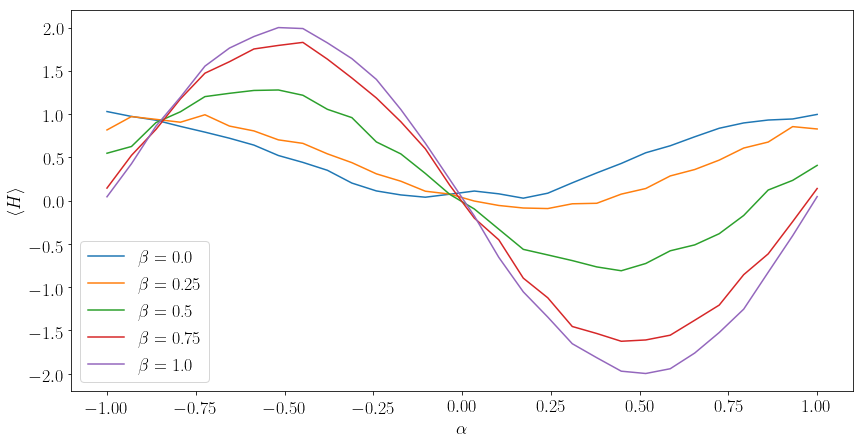

In [13]:
plt.rc('text',usetex=True)
plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(figsize=(14, 7))

for ii, vv in enumerate(beta):
    ax.plot(alpha,full_energy_list[ii],linestyle='-',label=r'$\beta=$ '+str(vv))

ax.set_ylabel(r'$\langle H\rangle$')
ax.set_xlabel(r'$\alpha$')
ax.legend()
plt.show()

The lowest energy $E_0$ corresponds to $-2.0$, and occurs when $\alpha=0.5$ and $\beta=1.0$, that is, when $| \psi_0 \rangle = \frac{1}{\sqrt{2}} |01\rangle +\frac{1}{\sqrt{2}} |10\rangle$. Using the Variational Quantum Eigensolver, we have successfully discovered the lowest energy of the system, $E_0$, and its associated eigenstate, $| \psi_0 \rangle$, for our Hamiltonian $H$.

# Finding the Minimum (Using Minimizer)

In [14]:
from scipy.optimize import minimize

In [15]:
# scipy.optimize.minimize shenanigans
def full_energy_2(x):
    return full_energy(*x)

In [16]:
x0 = [-0.5, 0.5]

In [17]:
result = minimize(full_energy_2, x0, method='Powell', 
                  options={'ftol':0.1,'maxiter':10,'disp':True})

Optimization terminated successfully.
         Current function value: -2.030273
         Iterations: 2
         Function evaluations: 96


In [18]:
x_f = [(vv+1)%2 - 1 for vv in result.x]
print('Alpha is {:.2} and beta is {:.2}, with E_0 equal to {:.2}.'.format(*x_f, result.fun))

Alpha is 0.53 and beta is 1.0, with E_0 equal to -2.0.


Note that because the number of measurements is not infinite, there is an inherent stochasticity in the energy value obtained. The minimizer algorithm that you use should be at least somewhat robust to this. It is usually better to avoid minimizers that rely on first or second derivatives, since they will usually fail to converge.